In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm
import io
import seaborn as sns
import os
from os import listdir
from os.path import isfile, join
import colorcet as cc
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

In [23]:
# def plot_query(path, join="median"):
#     query_data = []
#     subfoldersIndex = [f.path for f in os.scandir(path) if f.is_dir()]
#     for directory in subfoldersIndex:
#         onlyfiles = [f.path for f in os.scandir(directory) if ((f.is_file()) and ('stats' not in f.path))]
#         for filePath in onlyfiles:
#             try:
#                 file = open(filePath)
#                 lines = file.readlines()
#                 data = [line.rstrip().split(",") for line in lines]
#                 index = data[0][0]
#                 pivot = data[0][2]
#                 data = data[2:]
#                 for i in range(0, len(data)):
#                     data[i] = [index, pivot] + data[i]
#                 query_data.extend(data)
#             finally:
#                 file.close()

#     columns = ["Índice", "Pivô", "K", "Tempo", "Cálculos_de_distância", "Acessos_ao_disco"]
#     query_data.insert(0, columns)            
#     data = [" ".join(line) for line in query_data]
#     df = pd.read_csv(io.StringIO('\n'.join(data)), delim_whitespace=True)
#     df = df[df["Pivô"] != "RANDOM"]
#     group_df = pd.DataFrame()
#     if(join == "mean"):
#         group_df = df.groupby(["Índice", "Pivô", "K"])[["Tempo", "Cálculos_de_distância", "Acessos_ao_disco"]].mean().reset_index()
#     else:
#         group_df = df.groupby(["Índice", "Pivô", "K"])[["Tempo", "Cálculos_de_distância", "Acessos_ao_disco"]].median().reset_index()
#     g = sns.FacetGrid(group_df, col="Pivô", hue="Índice", col_wrap=3, height=4, aspect=1, sharey=False)
#     g.map(sns.lineplot, "K", "Cálculos_de_distância")
#     g.set(xticks=np.arange(0,101,10))
#     g.set_xticklabels(np.arange(0,101,10))
#     g.set(ylabel="Cálculos de distância")
#     g.add_legend()

In [3]:
# plot_query("../../../../../tcc_expt/consultas/cities/")

In [3]:
# def plot_query(path, join="median"):
#     palette = sns.color_palette(cc.glasbey, n_colors=12)
#     query_data = []
#     subfoldersIndex = [f.path for f in os.scandir(path) if f.is_dir()]
#     for directory in subfoldersIndex:
#         onlyfiles = [f.path for f in os.scandir(directory) if ((f.is_file()) and ('stats' not in f.path))]
#         for filePath in onlyfiles:
#             try:
#                 file = open(filePath)
#                 lines = file.readlines()
#                 data = [line.rstrip().split(",") for line in lines]
#                 index = data[0][0]
#                 pivot = data[0][2]
#                 data = data[2:]
#                 for i in range(0, len(data)):
#                     data[i] = [index, pivot] + data[i]
#                 query_data.extend(data)
#             finally:
#                 file.close()

#     columns = ["Índice", "Pivô", "K", "Tempo", "Cálculos_de_distância", "Acessos_ao_disco"]
#     query_data.insert(0, columns)            
#     data = [" ".join(line) for line in query_data]
#     df = pd.read_csv(io.StringIO('\n'.join(data)), delim_whitespace=True)
#     df = df[df["Pivô"] != "RANDOM"]
#     group_df = pd.DataFrame()
#     if(join == "mean"):
#         group_df = df.groupby(["Índice", "Pivô", "K"])[["Tempo", "Cálculos_de_distância", "Acessos_ao_disco"]].mean().reset_index()
#     else:
#         group_df = df.groupby(["Índice", "Pivô", "K"])[["Tempo", "Cálculos_de_distância", "Acessos_ao_disco"]].median().reset_index()
#     g = sns.FacetGrid(group_df, col="Índice", hue="Pivô", col_wrap=4, height=4, aspect=1, sharey=False, 
#                       palette=palette, hue_kws=dict(marker=["o", "v", "^", "<", "s", "p", "P", "X", "d", "H", ">", "*"]))
#     g.map(sns.lineplot, "K", "Cálculos_de_distância")
#     g.set(xticks=np.arange(0,101,10))
#     g.set_xticklabels(np.arange(0,101,10))
#     g.set(ylabel="Cálculos de distância")
#     g.add_legend()

def plot_query(path, join="median"):
    palette = sns.color_palette(cc.glasbey, n_colors=12)
    subfoldersIndex = [f.path for f in os.scandir(path) if f.is_dir()]
    pivos = ["BPP", "CONVEX", "GNAT", "SSS", "MAXSEPARATED", "MAXVARIANCE", "PCA", "IS", "HFI", "WDR", "SELECTION", "KMEDOIDS", "RANDOM"]
    
    df = pd.DataFrame(columns=["Índice", "Pivô", "K", "Tempo", "Cálculos_de_distância", "Acessos_ao_disco"])
    for indexPath in subfoldersIndex:
        files = [f for f in os.scandir(indexPath) if (f.is_file()) and ("stats" not in f.path)]
        for pvt in pivos:
            pivo_files = [f for f in files if pvt in f.path]
            pvtDF = pd.DataFrame()
            index = str()
            pivot = str()
            for f in pivo_files:
                file = open(f)
                line = file.readline().rstrip().split(",")
                index = line[0]
                pivot = line[2]
                dfAux = pd.read_csv(f, sep=',', skiprows=1, header=0)
                pvtDF = pd.concat([pvtDF, dfAux])
            
            if len(pvtDF) != 0:
                pvtDF["index"] = index
                pvtDF["pivot"] = pivot
                pvtDF = pvtDF.groupby(["index", "pivot", "k"])[["time", "count", "disk"]].mean().reset_index()
                pvtDF = pvtDF[["index", "pivot", "k", "time", "count", "disk"]]
                pvtDF.columns = ["Índice", "Pivô", "K", "Tempo", "Cálculos_de_distância", "Acessos_ao_disco"]
                df = pd.concat([df, pvtDF])
        
    df = df[df["Pivô"] != "RANDOM"]
    
    indexOrder = ["VPTREE", "MVPTREE", "OMNIKDTREE", "PMTREE", "SPBTREE"]
    df2 = pd.DataFrame(columns=df.columns)
        
    for index in indexOrder:
        dfAux = df[df["Índice"] == index]
        df2 = pd.concat([df2, dfAux])

    g = sns.FacetGrid(df2, col="Índice", hue="Pivô", col_wrap=4, height=4, aspect=1, sharey=False, 
                      palette=palette, hue_kws=dict(marker=["o", "v", "^", "<", "s", "p", "P", "X", "d", "H", ">", "*"]))
    g.map(sns.lineplot, "K", "Cálculos_de_distância")
    g.set(xticks=np.arange(0,101,10))
    g.set_xticklabels(np.arange(0,101,10))
    g.set(ylabel="Cálculos de distância")
    g.add_legend()
    plt.savefig("p1.svg", dpi=300)
            

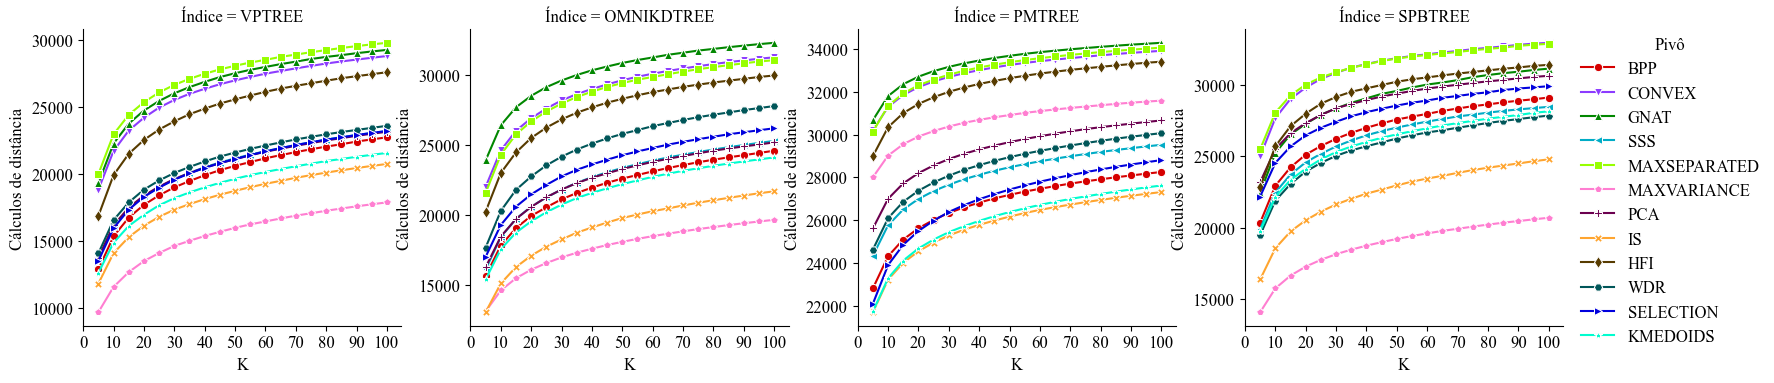

In [6]:
plot_query("../../../../../tcc_expt/consultas/nasa")

In [166]:
# def autolabel(rects, maxV, fmt='.2f'):
#     # attach some text labels
#     for rect in rects:
#         height = rect.get_height()
#         rect.axes.annotate(f'{{:{fmt}}}'.format(height),
#                            xy=(rect.get_x()+rect.get_width()/2., 0),
#                            xytext=(0, 3), textcoords='offset points',
#                            ha='center', va='bottom', rotation=90)
def autolabel(rects, maxV, fmt='.2f'):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        rect.axes.annotate(f'{{:{fmt}}}'.format(height),
                           xy=(rect.get_x()+rect.get_width()/2., height/1000), rotation=90, ha='center', va='bottom')

In [173]:
def plot_build(path, join="median"):
    palette = sns.color_palette(cc.glasbey, n_colors=12)
    query_data = []
    subfoldersIndex = [f.path for f in os.scandir(path) if f.is_dir()]
    for directory in subfoldersIndex:
        onlyfiles = [f.path for f in os.scandir(directory) if ((f.is_file()) and ('stats' in f.path))]
        for filePath in onlyfiles:
            try:
                file = open(filePath)
                lines = file.readlines()
                data = [line.rstrip().split(",") for line in lines]
                index = data[0][0]
                pivot = data[0][2]
                data = data[2:]
                for i in range(0, len(data)):
                    data[i] = [index, pivot] + data[i]
                #print(data)
                query_data.extend(data)
            finally:
                file.close()
    
    columns = ["Índice", "Pivô", "Tempo", "Cálculos_de_distância"]
    query_data.insert(0, columns)            
    data = [" ".join(line) for line in query_data]
    df = pd.read_csv(io.StringIO('\n'.join(data)), delim_whitespace=True)
    df = df[df["Pivô"] != "RANDOM"]
    df["Tempo"] = df["Tempo"]/1e6
    group_df = pd.DataFrame()

    if(join == "mean"):
        group_df = df.groupby(["Índice", "Pivô"])[["Tempo", "Cálculos_de_distância"]].mean().reset_index()
    else:
        group_df = df.groupby(["Índice", "Pivô"])[["Tempo", "Cálculos_de_distância"]].median().reset_index()

    indexOrder = ["VPTREE", "MVPTREE", "OMNIKDTREE", "PMTREE", "SPBTREE"]
    df2 = pd.DataFrame(columns=group_df.columns)
    maxy = []
    
    for index in indexOrder:
        dfAux = group_df[group_df["Índice"] == index]
        if dfAux.size != 0:
            tempoAux = dfAux["Tempo"].sort_values(ascending=False).values.tolist()
            #print(tempoAux)
            maxy.append(tempoAux[3]) 
            df2 = pd.concat([df2, dfAux])
        
    #print(maxy)
        
    #plt.figure(figsize=(8,6))
    g = sns.catplot(data=df2, x="Pivô", y="Tempo", hue="Pivô", col="Índice", kind="bar", dodge=False, 
                    palette=palette, sharey=False)
    g.set_xticklabels(rotation=45, ha='right')
    g.set(ylabel="Tempo (ms)")
    
    for (i,ax) in enumerate(g.axes.flatten()):
        #autolabel(ax.patches)
        ax.set(ylim=(0, maxy[i]))
        autolabel(ax.patches, maxy[i])
#         ax.yticks=np.arange(0,maxy[i],10)
#         ax.set_yticklabels(np.arange(0,maxy[i],10))
        


/tmp/ipykernel_263168/123729841.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,maxy[i],10))


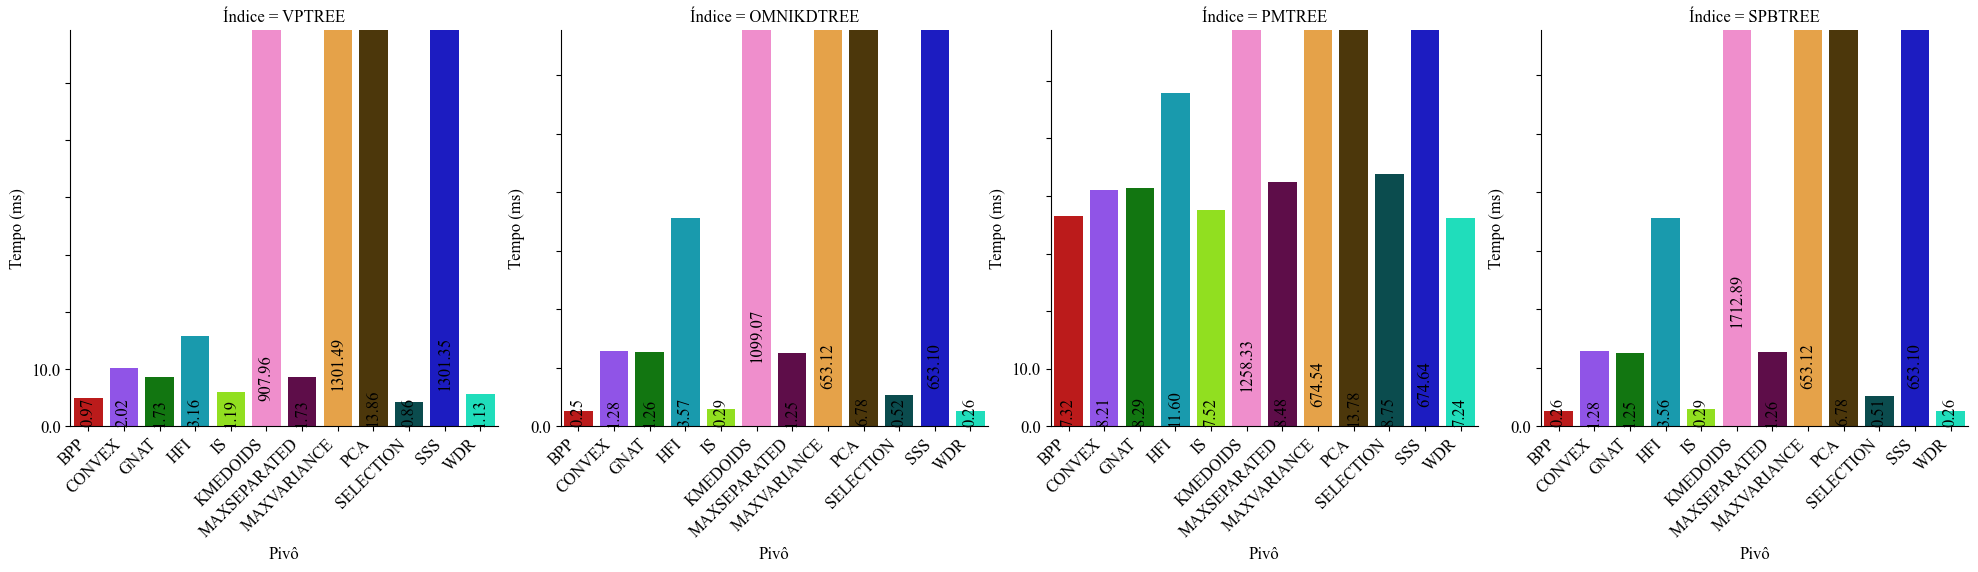

In [174]:
plot_build("../../../../../tcc_expt/consultas/nasa")

In [2]:
# path = "../results/mnist_results/"

In [3]:
# index_path = [join(path, "omni_results/"), join(path, "vp_results/"), join(path, "pm_results/"), join(path, "mvp_results")]

# query_data = []

# for directory in index_path:
#     subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]
#     for rep in subfolders:
#         onlyfiles = [join(rep,f) for f in listdir(rep) if isfile(join(rep, f))]
#         for filePath in onlyfiles:
#             try:
#                 file = open(filePath)
#                 lines = file.readlines()
#                 data = [line.rstrip().split(",") for line in lines]
#                 index = data[0][0]
#                 pivot = data[0][2]
#                 data = data[2:]

#                 for i in range(0, len(data)):
#                     data[i] = [index, pivot] + data[i]

#                 query_data.extend(data)
#             finally:
#                 file.close()

# columns = ["Index", "Pivot", "K", "Time", "Distance_Count", "Disk_Access"]
# query_data.insert(0, columns)
# data = [" ".join(line) for line in query_data]
# df = pd.read_csv(io.StringIO('\n'.join(data)), delim_whitespace=True)

In [4]:
# group_df = df.groupby(["Index", "Pivot", "K"])[["Time", "Distance_Count", "Disk_Access"]].mean().reset_index()
# group_df

In [5]:
# g = sns.FacetGrid(group_df, col="Pivot", hue="Index", col_wrap=3, height=4, aspect=1)
# g.map(sns.lineplot, "K", "Distance_Count")
# g.set(xticks=np.arange(0,101,10))
# g.set_xticklabels(np.arange(0,101,10))
# g.add_legend()

In [6]:
# def plot_query(path, join="median"):
#     query_data = []
#     subfoldersIndex = [f.path for f in os.scandir(path) if f.is_dir()]
#     for directory in subfoldersIndex:
#         subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]
#         for rep in subfolders:
#             onlyfiles = [f.path for f in os.scandir(rep) if f.is_file()]
#             for filePath in onlyfiles:
#                 try:
#                     file = open(filePath)
#                     lines = file.readlines()
#                     data = [line.rstrip().split(",") for line in lines]
#                     index = data[0][0]
#                     pivot = data[0][2]
#                     data = data[2:]

#                     for i in range(0, len(data)):
#                         data[i] = [index, pivot] + data[i]

#                     query_data.extend(data)
#                 finally:
#                     file.close()

#     columns = ["Index", "Pivot", "K", "Time", "Distance_Count", "Disk_Access"]
#     query_data.insert(0, columns)
#     data = [" ".join(line) for line in query_data]
#     df = pd.read_csv(io.StringIO('\n'.join(data)), delim_whitespace=True)
#     df = df[df.Pivot != "RANDOM"]
#     group_df = pd.DataFrame()
#     if(join == "mean"):
#         group_df = df.groupby(["Index", "Pivot", "K"])[["Time", "Distance_Count", "Disk_Access"]].mean().reset_index()
#     else:
#         group_df = df.groupby(["Index", "Pivot", "K"])[["Time", "Distance_Count", "Disk_Access"]].median().reset_index()
#     g = sns.FacetGrid(group_df, col="Pivot", hue="Index", col_wrap=3, height=4, aspect=1, sharey=False)
#     g.map(sns.lineplot, "K", "Distance_Count")
#     g.set(xticks=np.arange(0,101,10))
#     g.set_xticklabels(np.arange(0,101,10))
#     g.set(ylabel="Distance Count")
#     g.add_legend()